In [46]:
import pickle
import networkx as nx
from networkx.linalg.graphmatrix import adjacency_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import pymc as pm
import math
import numpy as np
from collections import Counter
from scipy.spatial.distance import pdist, squareform
from matplotlib.lines import Line2D

# Ex.1 - Most influencial nodes from political factions

## Preparing data

In [47]:
G = pickle.load(open('ex_1_graph.pickle', 'rb'))

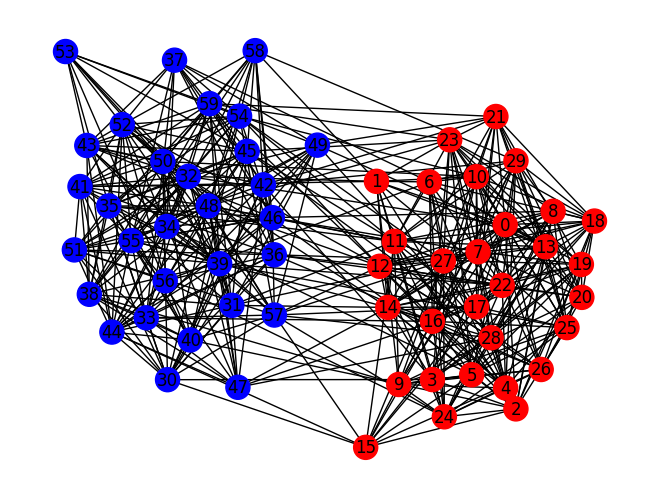

In [48]:
colors = ['red' if G.nodes[n].get('faction') == 'A' else 'blue' for n in G.nodes()]
nx.draw(G, node_color=colors, with_labels=True)

In [49]:
n = G.number_of_nodes()
adj_matrix = adjacency_matrix(G)
adj_matrix_arr = adj_matrix.toarray()
factions = [G.nodes[i]['faction'] for i in range(n)]

# Separate nodes by faction
faction_A = [i for i in range(n) if factions[i] == 'A']
faction_B = [i for i in range(n) if factions[i] == 'B']

messages_matrix = np.zeros((n,n), dtype=int)
for i in range(n):
  for j in range(n):
    edge_data = G.get_edge_data(i,j)
    messages_matrix[i][j]=edge_data['messages'] if edge_data is not None else 0

print(messages_matrix)
mask = np.triu(np.ones((n,n), dtype=bool), k=1)
messages_vec = messages_matrix[mask]


[[ 0 21 37 ...  0  0  0]
 [21  0 21 ...  0  3  0]
 [37 21  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  3  0 ...  0  0 26]
 [ 0  0  0 ...  0 26  0]]


## Checking data distribution

Based on the frequency distribution of daily messages, I am modeling the data with a Poisson distribution. Although there is some overdispersion (variance > mean) present, the data still meets the core assumptions of the Poisson process: discrete, independent events occurring at a roughly constant rate. Using Poisson provides a simple and interpretable starting point for inference on the average messaging rate.

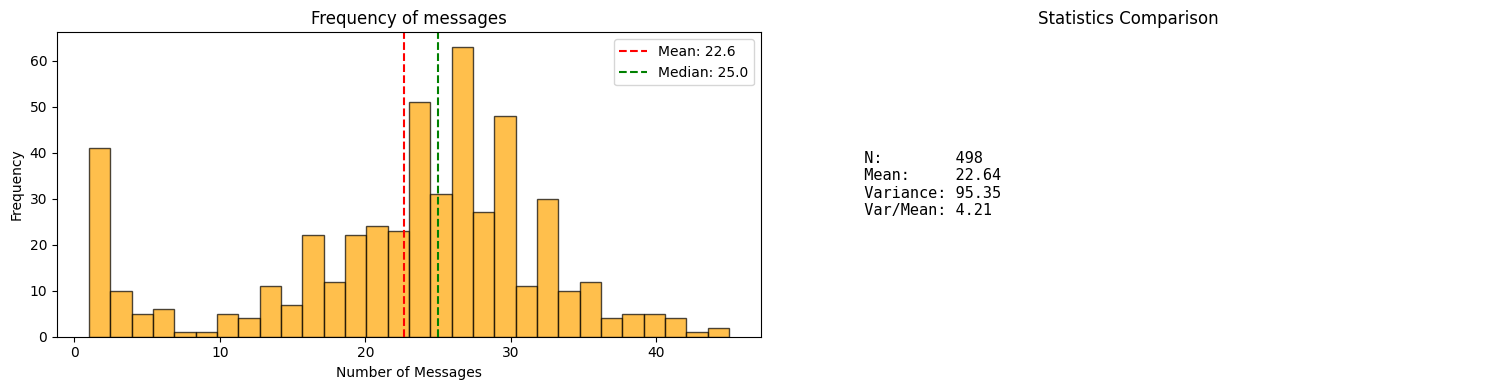

In [87]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

non_zero = messages_vec[messages_vec > 0]
axes[0].hist(non_zero, bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[0].set_xlabel('Number of Messages')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Frequency of messages')
axes[0].axvline(non_zero.mean(), color='red', linestyle='--', label=f'Mean: {non_zero.mean():.1f}')
axes[0].axvline(np.median(non_zero), color='green', linestyle='--', label=f'Median: {np.median(non_zero):.1f}')
axes[0].legend()

stats_text = f"""
  N:        {len(non_zero)}
  Mean:     {non_zero.mean():.2f}
  Variance: {non_zero.var():.2f}
  Var/Mean: {non_zero.var()/non_zero.mean():.2f}
"""
axes[1].text(0.1, 0.5, stats_text, fontsize=11, fontfamily='monospace',
             verticalalignment='center', transform=axes[1].transAxes)
axes[1].set_title('Statistics Comparison')
axes[1].axis('off')

plt.tight_layout()
plt.show()

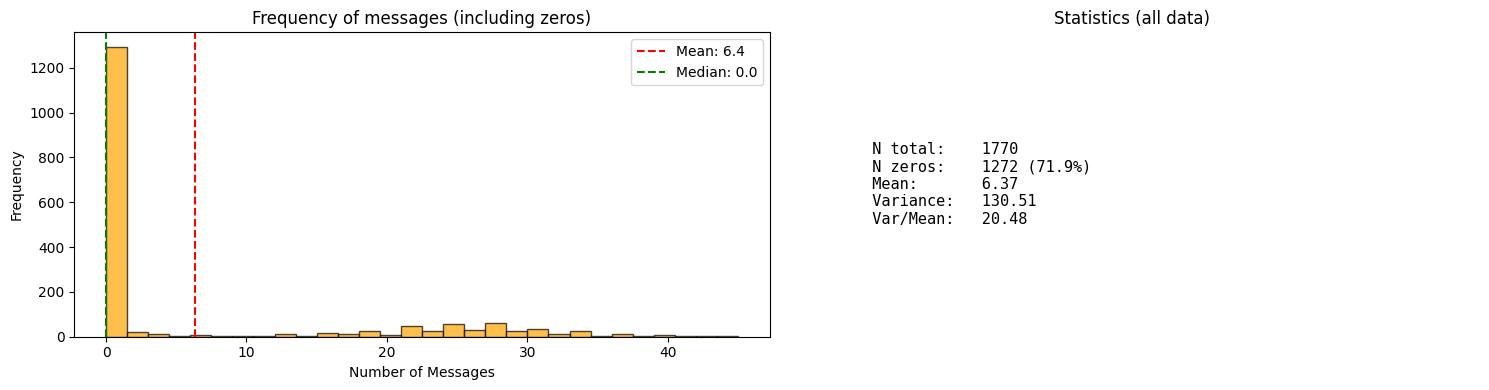

In [88]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

# Use all data including zeros
axes[0].hist(messages_vec, bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[0].set_xlabel('Number of Messages')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Frequency of messages (including zeros)')
axes[0].axvline(messages_vec.mean(), color='red', linestyle='--', label=f'Mean: {messages_vec.mean():.1f}')
axes[0].axvline(np.median(messages_vec), color='green', linestyle='--', label=f'Median: {np.median(messages_vec):.1f}')
axes[0].legend()

# Stats for all data
n_zeros = np.sum(messages_vec == 0)
stats_text = f"""
  N total:    {len(messages_vec)}
  N zeros:    {n_zeros} ({100*n_zeros/len(messages_vec):.1f}%)
  Mean:       {messages_vec.mean():.2f}
  Variance:   {messages_vec.var():.2f}
  Var/Mean:   {messages_vec.var()/messages_vec.mean():.2f}
"""
axes[1].text(0.1, 0.5, stats_text, fontsize=11, fontfamily='monospace',
             verticalalignment='center', transform=axes[1].transAxes)
axes[1].set_title('Statistics (all data)')
axes[1].axis('off')

plt.tight_layout()
plt.show()

## Probabilistic model

 Based on Hoff's latent distance model, where message frequency between users depends on their distance in an unobserved social space.

**Model Formulation**:

$\lambda_{ij} = \exp(\beta_0 - \|U_i - U_j\|)$  
$Y_{ij} \sim \text{Poisson}(\lambda_{ij})$

**Components**:
- $U_i \in \mathbb{R}^2$: Latent position of user $i$ in 2D social space
- $\beta_0$ (intercept): Baseline log-rate when distance = 0
- $\|U_i - U_j\|$: Euclidean distance between users $i$ and $j$
- Interpretation: Closer users : higher message rates (exponential decay with distance)

**Why use this model?**
- Captures social clustering naturally
- Accounts for unobserved user similarities
- Bayesian approach quantifies uncertainty in positions and effects
- Flexible enough to handle varying interaction frequencies

In [ ]:
with pm.Model() as model_ex1:
  #latent space
  K=2

  #priors for variance, intercept and vectors positions in latent space
  sigma_u = pm.HalfNormal("sigma_u", sigma=1)

  # Latent positions
  U = pm.Normal("U", mu=0, sigma=sigma_u, shape=(n, K))

  intercept=pm.Normal("intercept",mu=3,sigma=3)

  #squared norms
  sq_norms = pm.math.sum(U**2, axis=1)
  D_2=sq_norms[:, None] + sq_norms[None, :]- 2*pm.math.dot(U, U.T)
  D=pm.math.sqrt(D_2+1e-6)

  #likelihood
  D_vec= D[mask]

  lambda_ij=pm.math.exp(intercept-D_vec)
  pm.Poisson("edges", mu=lambda_ij, observed=messages_vec)

  step = pm.NUTS(target_accept=0.95)
  trace = pm.sample(draws=4000, tune=2000, step=step, chains=4, cores=4,progressbar=True, return_inferencedata=True, random_seed=42)


Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


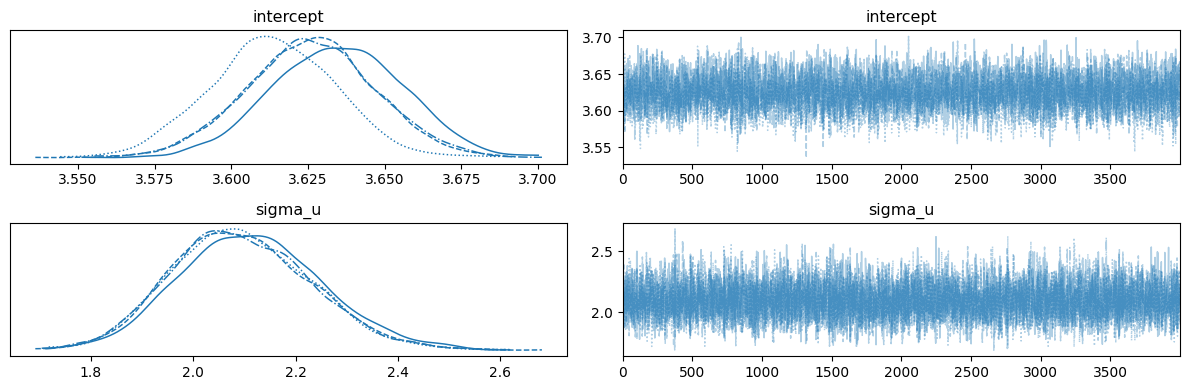

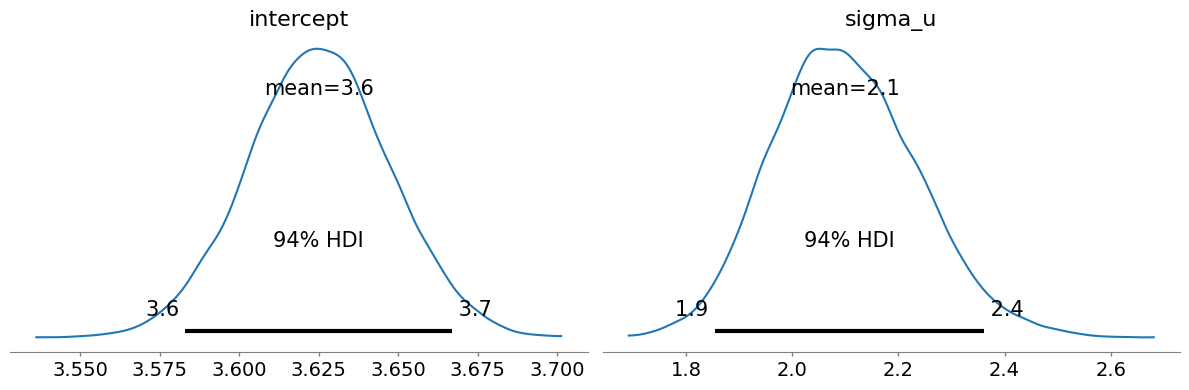

            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
intercept  3.625  0.022   3.583    3.667      0.004    0.000      35.0   
sigma_u    2.098  0.136   1.855    2.362      0.002    0.001    6620.0   

           ess_tail  r_hat  
intercept     569.0   1.07  
sigma_u      7034.0   1.00  


In [52]:
# Check convergence
az.plot_trace(trace, var_names=["intercept", "sigma_u"])
plt.tight_layout()
plt.show()

# Posterior distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
az.plot_posterior(trace, var_names=["intercept"], ax=axes[0])
az.plot_posterior(trace, var_names=["sigma_u"], ax=axes[1])
plt.tight_layout()
plt.show()

# Summary statistics
print(az.summary(trace, var_names=["intercept", "sigma_u"]))

### Results Summary

**Parameter Estimates:**
- Intercept (β₀): 3.625 (HDI: 3.58–3.67): Baseline log-rate when users coincide
- σᵤ: 2.10 (HDI: 1.86–2.36) : Substantial spread in latent positions

**Interpretation:**
- When distance = 0: Expected messages = exp(3.625) ≈ **37.5**
- Distance effect: Each 1-unit increase: rate × exp(−1) ≈ **37% reduction**
- Users are meaningfully separated in latent space (σᵤ > 0)

**Diagnostics:**  
σᵤ converged well (R-hat=1.00, ESS>6000); intercept shows slight mixing concern.

## Latent space plot

The latent positions separate cleanly into two distinct clusters, corresponding to the two factions in the data.

Faction A: Forms a relatively linear, cohesive cluster

Faction B: Shows greater dispersion across the latent space

This suggests Faction A members are more socially aligned/interconnected, while Faction B exhibits more varied positioning relative to others.

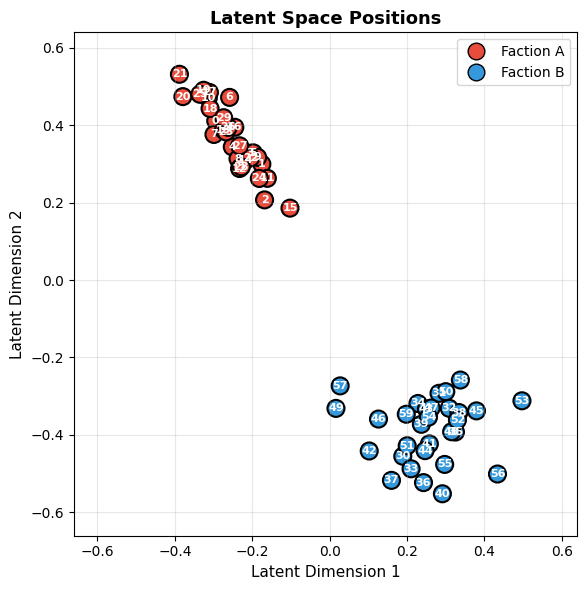

In [53]:
# Extract positions
U_samples = trace.posterior["U"].values
U_mean = U_samples.mean(axis=(0, 1))

fig, ax = plt.subplots(figsize=(6, 6))

colors = ['#e74c3c' if factions[i] == 'A' else '#3498db' for i in range(n)]
ax.scatter(U_mean[:, 0], U_mean[:, 1], c=colors, s=150, edgecolors='black', linewidth=1.5)

# Labels
for i in range(n):
    ax.annotate(str(i), (U_mean[i, 0], U_mean[i, 1]),
                ha='center', va='center', fontsize=8,
                fontweight='bold', color='white')

# Legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#e74c3c',
           markersize=12, label='Faction A', markeredgecolor='black'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#3498db',
           markersize=12, label='Faction B', markeredgecolor='black'),
]
ax.legend(handles=legend_elements, loc='best', fontsize=10)

ax.set_xlabel('Latent Dimension 1', fontsize=11)
ax.set_ylabel('Latent Dimension 2', fontsize=11)
ax.set_title('Latent Space Positions', fontsize=13, fontweight='bold')
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)

x_min, x_max = U_mean[:, 0].min(), U_mean[:, 0].max()
y_min, y_max = U_mean[:, 1].min(), U_mean[:, 1].max()
all_min = min(x_min, y_min)
all_max = max(x_max, y_max)
margin = (all_max - all_min) * 0.1  # 10% margin
ax.set_xlim(all_min - margin, all_max + margin)
ax.set_ylim(all_min - margin, all_max + margin)

plt.tight_layout()
plt.show()

## Posterior predictive check to see if our model replicates well the data

In [55]:
def simulate_messages(U, intercept):
    D = squareform(pdist(U))
    lambda_matrix = np.exp(intercept - D)
    np.fill_diagonal(lambda_matrix, 0)
    return np.random.poisson(lambda_matrix)

In [56]:
# Get posterior samples
U_samples = trace.posterior["U"].values
intercept_samples = trace.posterior["intercept"].values

n_chains, n_draws, n_nodes, K = U_samples.shape

# Flatten chains
U_flat = U_samples.reshape(-1, n_nodes, K)
intercept_flat = intercept_samples.flatten()

# Generate replicated datasets
n_rep = 1000
replicated_data = []

np.random.seed(42)
sample_indices = np.random.choice(len(U_flat), size=n_rep, replace=False)

for idx in sample_indices:
    M_rep = simulate_messages(U_flat[idx], intercept_flat[idx])
    replicated_data.append(M_rep[mask])

replicated_data = np.array(replicated_data)

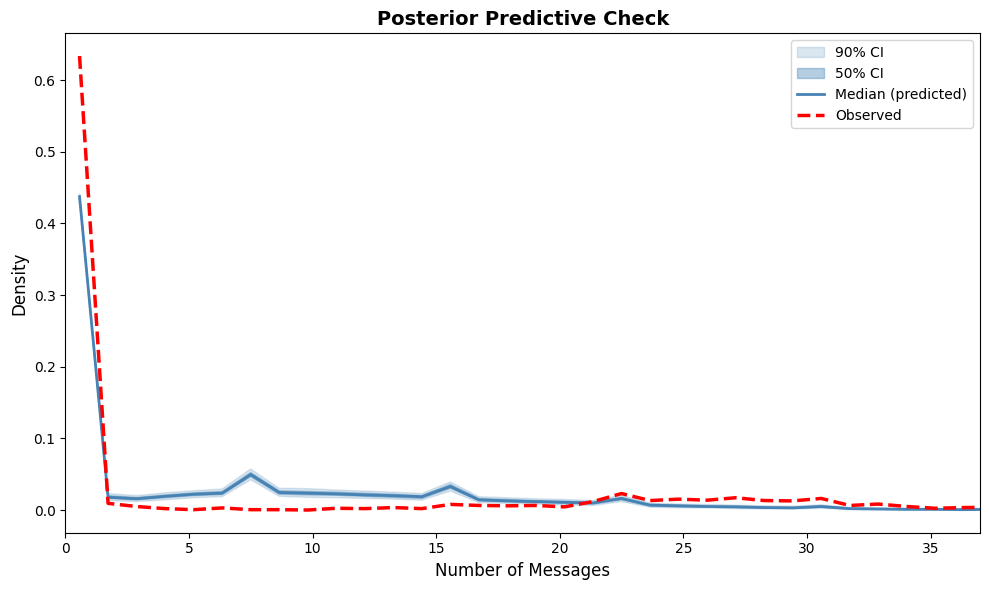

In [57]:
fig, ax = plt.subplots(figsize=(10, 6))

# Compute percentiles for each bin
bins = np.linspace(0, messages_vec.max(), 40)
bin_centers = (bins[:-1] + bins[1:]) / 2

rep_hists = []
for i in range(n_rep):
    counts, _ = np.histogram(replicated_data[i], bins=bins, density=True)
    rep_hists.append(counts)
rep_hists = np.array(rep_hists)

# Percentiles
p5 = np.percentile(rep_hists, 5, axis=0)
p25 = np.percentile(rep_hists, 25, axis=0)
p50 = np.percentile(rep_hists, 50, axis=0)
p75 = np.percentile(rep_hists, 75, axis=0)
p95 = np.percentile(rep_hists, 95, axis=0)

# Plot
ax.fill_between(bin_centers, p5, p95, alpha=0.2, color='steelblue', label='90% CI')
ax.fill_between(bin_centers, p25, p75, alpha=0.4, color='steelblue', label='50% CI')
ax.plot(bin_centers, p50, color='steelblue', linewidth=2, label='Median (predicted)')

# Observed
obs_counts, _ = np.histogram(messages_vec, bins=bins, density=True)
ax.plot(bin_centers, obs_counts, color='red', linewidth=2.5, label='Observed', linestyle='--')

ax.set_xlabel('Number of Messages', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title('Posterior Predictive Check', fontsize=14, fontweight='bold')
ax.legend(loc='upper right')
ax.set_xlim(0, np.percentile(messages_vec, 99))
plt.tight_layout()
plt.show()

**Model Fit:** Good : observed distribution falls within predicted credible intervals.

**Observations:**

- Median prediction tracks overall shape closely
- Slight misfit at extremes (very low/high counts)
- Peak location slightly offset

**Conclusion:** Fit is sufficient for inference and latent structure analysis.

## Question 1 - finding the most influencial politician of each faction

**Goal:** Identify the most influential nodes within each faction based on latent positions.

**Method:**
1. Within-faction influence = `1 / mean_distance_to_other_faction_members`
   - Closer average distance : higher influence
   - Node with smallest mean distance = most central/influential
2. Posterior probability of being #1 calculated across all MCMC samples

In [61]:
def within_faction_influence(node, same_faction, D):
    others = [j for j in same_faction if j != node]
    if len(others) == 0:
        return 0
    return 1 / np.mean([D[node, j] for j in others])

In [62]:
# Get U samples directly (no alignment needed)
U_samples = trace.posterior["U"].values
n_chains, n_draws, n_nodes, K = U_samples.shape

# Flatten chains and draws into one dimension
U_flat = U_samples.reshape(-1, n_nodes, K)  # Shape: (n_samples, n_nodes, 2)

# Count how many times each node is ranked #1
top1_counts_A = Counter()
top1_counts_B = Counter()

all_influence_A = {i: [] for i in faction_A}
all_influence_B = {i: [] for i in faction_B}

n_samples = len(U_flat)

for idx in range(n_samples):
    U = U_flat[idx]
    D = squareform(pdist(U))

    # Compute influence for each node
    inf_A = {i: within_faction_influence(i, faction_A, D) for i in faction_A}
    inf_B = {i: within_faction_influence(i, faction_B, D) for i in faction_B}

    # Store scores
    for i in faction_A:
        all_influence_A[i].append(inf_A[i])
    for i in faction_B:
        all_influence_B[i].append(inf_B[i])

    # Track who is #1
    top1_counts_A[max(inf_A, key=inf_A.get)] += 1
    top1_counts_B[max(inf_B, key=inf_B.get)] += 1

# Convert to probabilities
prob_top1_A = {node: count / n_samples for node, count in top1_counts_A.items()}
prob_top1_B = {node: count / n_samples for node, count in top1_counts_B.items()}

# Fill zeros for nodes that were never top
for i in faction_A:
    if i not in prob_top1_A:
        prob_top1_A[i] = 0.0
for i in faction_B:
    if i not in prob_top1_B:
        prob_top1_B[i] = 0.0

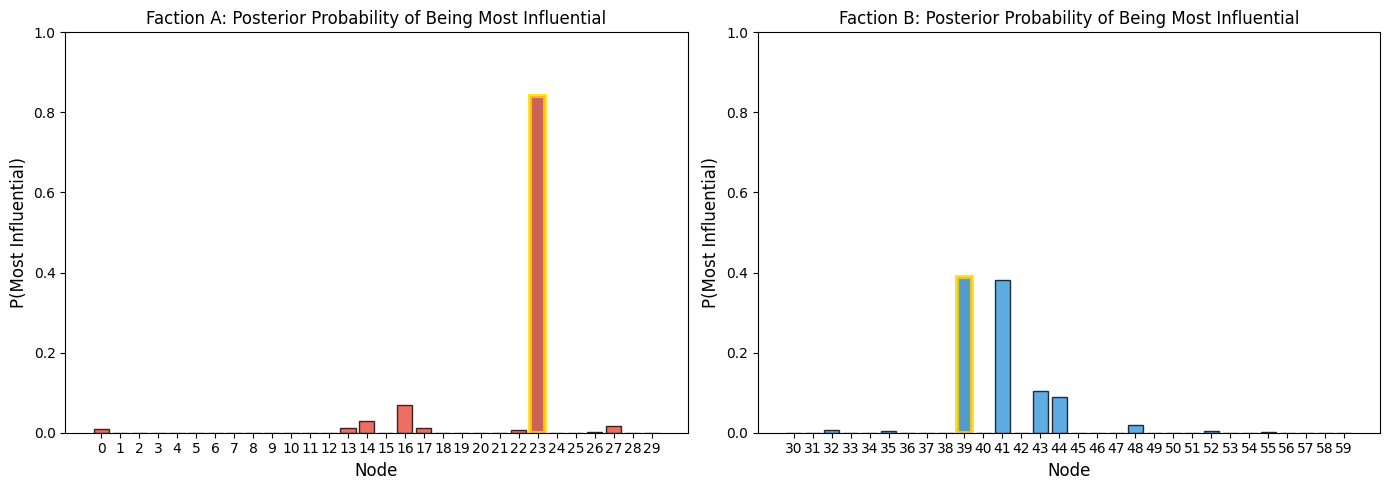

In [63]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Faction A
nodes_A = sorted(faction_A)
probs_A = [prob_top1_A[i] for i in nodes_A]
bars_A = axes[0].bar(nodes_A, probs_A, color='#e74c3c', edgecolor='black', alpha=0.8)
axes[0].set_xlabel('Node', fontsize=12)
axes[0].set_ylabel('P(Most Influential)', fontsize=12)
axes[0].set_title('Faction A: Posterior Probability of Being Most Influential', fontsize=12)
axes[0].set_xticks(nodes_A)
axes[0].set_ylim(0, 1)

# Highlight winner
max_node_A = max(prob_top1_A, key=prob_top1_A.get)
max_idx_A = nodes_A.index(max_node_A)
bars_A[max_idx_A].set_color('#c0392b')
bars_A[max_idx_A].set_edgecolor('gold')
bars_A[max_idx_A].set_linewidth(3)

# Faction B
nodes_B = sorted(faction_B)
probs_B = [prob_top1_B[i] for i in nodes_B]
bars_B = axes[1].bar(nodes_B, probs_B, color='#3498db', edgecolor='black', alpha=0.8)
axes[1].set_xlabel('Node', fontsize=12)
axes[1].set_ylabel('P(Most Influential)', fontsize=12)
axes[1].set_title('Faction B: Posterior Probability of Being Most Influential', fontsize=12)
axes[1].set_xticks(nodes_B)
axes[1].set_ylim(0, 1)

# Highlight winner
max_node_B = max(prob_top1_B, key=prob_top1_B.get)
max_idx_B = nodes_B.index(max_node_B)
bars_B[max_idx_B].set_color('#2980b9')
bars_B[max_idx_B].set_edgecolor('gold')
bars_B[max_idx_B].set_linewidth(3)

plt.tight_layout()
plt.show()

**Interpretation:**
- Bars show probability each node is the *most influential* in its faction
- Gold-highlighted bars: Most likely influencers
- Probabilities < 1.0 indicate uncertainty/competition for top position
- Faction A shows clearer dominance structure than Faction B

In [64]:
print("MOST INFLUENTIAL POLITICIAN")
print(f"\nFaction A: Node {max_node_A} with P = {prob_top1_A[max_node_A]:.1%}")
print("  Full ranking:")
for node, prob in sorted(prob_top1_A.items(), key=lambda x: -x[1]):
    if prob > 0:
        print(f"    Node {node}: {prob:.1%}")

print(f"\nFaction B: Node {max_node_B} with P = {prob_top1_B[max_node_B]:.1%}")
print("  Full ranking:")
for node, prob in sorted(prob_top1_B.items(), key=lambda x: -x[1]):
    if prob > 0:
        print(f"    Node {node}: {prob:.1%}")

MOST INFLUENTIAL POLITICIAN

Faction A: Node 23 with P = 84.2%
  Full ranking:
    Node 23: 84.2%
    Node 16: 7.0%
    Node 14: 2.9%
    Node 27: 1.8%
    Node 13: 1.2%
    Node 17: 1.1%
    Node 0: 0.8%
    Node 22: 0.7%
    Node 26: 0.3%
    Node 24: 0.0%
    Node 25: 0.0%

Faction B: Node 39 with P = 38.9%
  Full ranking:
    Node 39: 38.9%
    Node 41: 38.0%
    Node 43: 10.4%
    Node 44: 8.9%
    Node 48: 1.9%
    Node 32: 0.7%
    Node 52: 0.5%
    Node 35: 0.5%
    Node 55: 0.1%
    Node 45: 0.0%
    Node 51: 0.0%
    Node 34: 0.0%


### Influence Ranking Interpretation

**Faction A – Clear Hierarchy:**
- Node 23 dominates with 84.2% probability of being most influential
- Strong central leader with minimal competition
- Clear power structure: top 3 nodes (23, 16, 14) account for 94% of top positions
- Hierarchical, stable leadership

**Faction B – Competitive Landscape:**
- Node 39 emerges as most likely leader but with only 38.9% probability
- Node 41 is nearly tied at 38.0% – effectively a statistical tie
- Top two nodes (39 & 41) account for 77% of top positions
- More distributed influence structure

**Observations:**
- **Faction A**: Centralized, stable leadership (Node 23 is clearly dominant)
- **Faction B**: Decentralized, competitive leadership (Nodes 39 and 41 share influence)

In [65]:
U_by_chain = trace.posterior["U"].values

for c in range(4):
    U_chain = U_by_chain[c]
    top1_A = Counter()

    for U in U_chain[::100]:
        D = squareform(pdist(U))
        inf_A = {i: within_faction_influence(i, faction_A, D) for i in faction_A}
        top1_A[max(inf_A, key=inf_A.get)] += 1

    print(f"Chain {c}: {top1_A.most_common(3)}")

Chain 0: [(23, 39), (27, 1)]
Chain 1: [(23, 21), (16, 6), (13, 6)]
Chain 2: [(23, 40)]
Chain 3: [(23, 39), (27, 1)]


**Interpretation**: Node 23 is chosen by all 4 chains with overwhelming majority

In [66]:
for c in range(4):
    U_chain = U_by_chain[c]
    top1_B = Counter()

    for U in U_chain[::100]:
        D = squareform(pdist(U))
        inf_B = {i: within_faction_influence(i, faction_B, D) for i in faction_B}
        top1_B[max(inf_B, key=inf_B.get)] += 1

    print(f"Chain {c}: {top1_B.most_common(3)}")

Chain 0: [(39, 30), (41, 10)]
Chain 1: [(41, 25), (39, 7), (44, 6)]
Chain 2: [(41, 15), (39, 11), (43, 8)]
Chain 3: [(41, 13), (39, 12), (43, 11)]


**Interpretation**: Nodes 39 and 41 appear in all 4 MCMC chains. This confirms their competitive relationship is robust across independent sampling runs

## Question 2 - finding best negotiator

**Goal:** Identify the best negotiator/bridge between factions.

**Method:**
1. **Negotiator Score** = (Internal Influence) ÷ (Average Distance to Other Faction)
   - Internal Influence: Closeness to own faction members
   - Distance to Other Faction: Proximity to the opposing faction
2. **Posterior probability** of being the top negotiator calculated across MCMC samples

In [58]:
def distance_to_other_faction(node, other_faction, D):
    return np.mean([D[node, j] for j in other_faction])

In [ ]:
# Count how many times each node is ranked #1 negotiator
top1_negotiator_A = Counter()
top1_negotiator_B = Counter()

all_negotiator_A = {i: [] for i in faction_A}
all_negotiator_B = {i: [] for i in faction_B}

n_samples = len(U_flat)

In [67]:
for idx in range(n_samples):
    U = U_flat[idx]
    D = squareform(pdist(U))

    # Influence scores + compute distance to other faction
    neg_A = {i: all_influence_A[i][idx] / distance_to_other_faction(i, faction_B, D) for i in faction_A}
    neg_B = {i: all_influence_B[i][idx] / distance_to_other_faction(i, faction_A, D) for i in faction_B}

    # Store scores
    for i in faction_A:
        all_negotiator_A[i].append(neg_A[i])
    for i in faction_B:
        all_negotiator_B[i].append(neg_B[i])

    # Track who is #1
    top1_negotiator_A[max(neg_A, key=neg_A.get)] += 1
    top1_negotiator_B[max(neg_B, key=neg_B.get)] += 1

# Convert to probabilities
prob_neg_A = {node: count / n_samples for node, count in top1_negotiator_A.items()}
prob_neg_B = {node: count / n_samples for node, count in top1_negotiator_B.items()}

# Fill zeros
for i in faction_A:
    if i not in prob_neg_A:
        prob_neg_A[i] = 0.0
for i in faction_B:
    if i not in prob_neg_B:
        prob_neg_B[i] = 0.0

In [68]:
print("BEST NEGOTIATOR")

max_neg_A = max(prob_neg_A, key=prob_neg_A.get)
max_neg_B = max(prob_neg_B, key=prob_neg_B.get)

print(f"\nFaction A: Node {max_neg_A} with P = {prob_neg_A[max_neg_A]:.1%}")
print("  Top candidates:")
for node, prob in sorted(prob_neg_A.items(), key=lambda x: -x[1])[:5]:
    if prob > 0:
        print(f"    Node {node}: {prob:.1%}")

print(f"\nFaction B: Node {max_neg_B} with P = {prob_neg_B[max_neg_B]:.1%}")
print("  Top candidates:")
for node, prob in sorted(prob_neg_B.items(), key=lambda x: -x[1])[:5]:
    if prob > 0:
        print(f"    Node {node}: {prob:.1%}")

BEST NEGOTIATOR

Faction A: Node 27 with P = 52.0%
  Top candidates:
    Node 27: 52.0%
    Node 23: 21.1%
    Node 22: 17.3%
    Node 13: 3.0%
    Node 14: 2.0%

Faction B: Node 39 with P = 40.2%
  Top candidates:
    Node 39: 40.2%
    Node 43: 37.9%
    Node 34: 6.3%
    Node 52: 3.8%
    Node 59: 3.5%


**Faction A:** Node 27 (52%) is the clear diplomatic representative.

**Faction B:** Nodes 39 (40%) and 43 (38%) are nearly tied as lead negotiators.

**Observation:** Most influential internally ≠ best negotiator across factions.

In [ ]:
for c in range(4):
    U_chain = trace.posterior["U"].values[c]
    top1_A = Counter()
    top1_B = Counter()

    for idx, U in enumerate(U_chain[::100]):
        D = squareform(pdist(U))
        neg_A = {i: within_faction_influence(i, faction_A, D) / np.mean([D[i,j] for j in faction_B]) for i in faction_A}
        neg_B = {i: within_faction_influence(i, faction_B, D) / np.mean([D[i,j] for j in faction_A]) for i in faction_B}
        top1_A[max(neg_A, key=neg_A.get)] += 1
        top1_B[max(neg_B, key=neg_B.get)] += 1

    print(f"Chain {c} - Negotiator A: {top1_A.most_common(3)} | Negotiator B: {top1_B.most_common(3)}")

Chain 0 - Negotiator A: [(27, 23), (23, 13), (22, 4)] | Negotiator B: [(43, 10), (34, 10), (39, 9)]
Chain 1 - Negotiator A: [(22, 16), (27, 10), (17, 4)] | Negotiator B: [(39, 32), (48, 5), (35, 2)]
Chain 2 - Negotiator A: [(27, 23), (23, 14), (22, 3)] | Negotiator B: [(43, 25), (39, 15)]
Chain 3 - Negotiator A: [(27, 26), (23, 11), (22, 2)] | Negotiator B: [(43, 29), (39, 11)]


**Faction A – Consistent Patterns:**
- Node 27 appears as top negotiator in 3 out of 4 chains (Chains 0, 2, 3)
- Node 22 emerges strongly in Chain 1, showing some alternative scenario

**Faction B – Chain Variability:**
- Chain 1 strongly favors Node 39 (32 samples)
- Chains 0, 2, 3 consistently favor Node 43
- Shows true ambiguity in Faction B's negotiation leadership

**Overall:** Multi-chain results confirm the competitive nature in Faction B and stable leadership in Faction A's negotiations.

## Final results plot

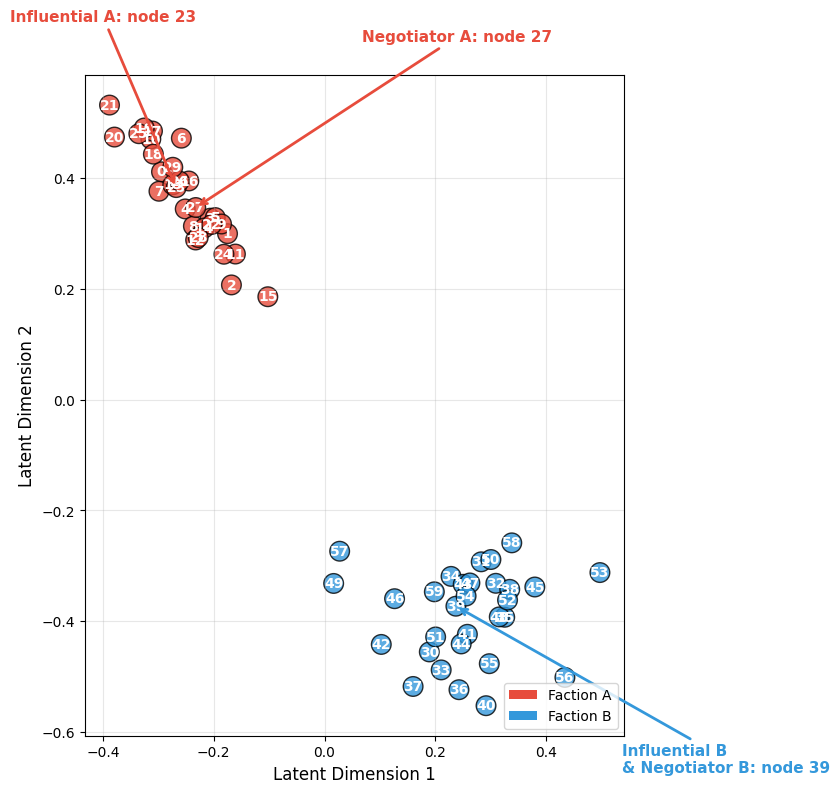

In [84]:
fig, ax = plt.subplots(figsize=(10, 8))

colors = ['#e74c3c' if factions[i] == 'A' else '#3498db' for i in range(n)]
ax.scatter(U_mean[:, 0], U_mean[:, 1], c=colors, s=200, edgecolor='black', alpha=0.8)

# Labels
for i in range(n):
    ax.text(U_mean[i, 0], U_mean[i, 1], str(i), ha='center', va='center', fontsize=10, color='white', fontweight='bold')

# Get nodes
influential_A = max_node_A
influential_B = max_node_B
negotiator_A = max_neg_A
negotiator_B = max_neg_B

offset = 0.15

# Faction A annotations
ax.annotate(f'Influential A: node {influential_A}', xy=(U_mean[influential_A, 0], U_mean[influential_A, 1]),
            xytext=(U_mean[influential_A, 0] - offset*2, U_mean[influential_A, 1] + offset*2),
            fontsize=11, color='#e74c3c', fontweight='bold',
            arrowprops=dict(arrowstyle='->', color='#e74c3c', lw=2))

ax.annotate(f'Negotiator A: node {negotiator_A}', xy=(U_mean[negotiator_A, 0], U_mean[negotiator_A, 1]),
            xytext=(U_mean[negotiator_A, 0] + offset*2, U_mean[negotiator_A, 1] + offset*2),
            fontsize=11, color='#e74c3c', fontweight='bold',
            arrowprops=dict(arrowstyle='->', color='#e74c3c', lw=2))

# Faction B annotations
if influential_B == negotiator_B:
    ax.annotate(f'Influential B\n& Negotiator B: node {influential_B}', xy=(U_mean[influential_B, 0], U_mean[influential_B, 1]),
                xytext=(U_mean[influential_B, 0] + offset*2, U_mean[influential_B, 1] - offset*2),
                fontsize=11, color='#3498db', fontweight='bold',
                arrowprops=dict(arrowstyle='->', color='#3498db', lw=2))
else:
    ax.annotate(f'Influential B {influential_B}', xy=(U_mean[influential_B, 0], U_mean[influential_B, 1]),
                xytext=(U_mean[influential_B, 0] + offset*2, U_mean[influential_B, 1] - offset*2),
                fontsize=11, color='#3498db', fontweight='bold',
                arrowprops=dict(arrowstyle='->', color='#3498db', lw=2))
    ax.annotate(f'Negotiator B', xy=(U_mean[negotiator_B, 0], U_mean[negotiator_B, 1]),
                xytext=(U_mean[negotiator_B, 0] - offset*2, U_mean[negotiator_B, 1] - offset*2),
                fontsize=11, color='#3498db', fontweight='bold',
                arrowprops=dict(arrowstyle='->', color='#3498db', lw=2))

# Styling
ax.set_xlabel('Latent Dimension 1', fontsize=12)
ax.set_ylabel('Latent Dimension 2', fontsize=12)
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)

# Faction legend
from matplotlib.patches import Patch
faction_handles = [Patch(facecolor='#e74c3c', label='Faction A'),
                   Patch(facecolor='#3498db', label='Faction B')]
ax.legend(handles=faction_handles, loc='lower right', fontsize=10)

plt.tight_layout()
plt.show()

### Final Thoughts & Conclusions

**Key Findings:**

1. **Clear Social Structure**: The latent distance model successfully identifies two distinct factions with different internal dynamics.

2. **Leadership Patterns**:
   - Faction A: Centralized, hierarchical leadership (Node 23 clearly dominant)
   - Faction B: Competitive, distributed leadership (Nodes 39 and 41 nearly tied)

3. **Role Specialization**:  
   - Most influential ≠ best negotiator
   - Node 23 (most influential in A) vs Node 27 (best negotiator in A)
   - Different positions in latent space serve different social functions

4. **Model Performance**:  
   - Posterior predictive checks show reasonable fit to observed message patterns
   - Captures right-skew and central tendency well
   - Some tail misfit expected with Poisson for overdispersed data

**Overall**: The model provides valuable insights into social structure and role differentiation within the political network.